In [127]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd
import datetime as dt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from scipy import stats

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Solar_Power"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Project Name:

Contribution:

Problem statement:

In [2]:
#import data
plant_1_gen = pd.read_csv("Plant_1_Generation_data.csv")
plant_2_gen = pd.read_csv("Plant_2_Generation_data.csv")
plant_1_wea = pd.read_csv("Plant_1_Weather_Sensor_data.csv")
plant_2_wea = pd.read_csv("Plant_2_Weather_Sensor_data.csv")


## Data Exploration
our dataset consist of 4 files 2 for each plant
- power generation data
- weather sensor data

### The power generations data consists of 7 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | DC_POWER | AC_POWER | DAILY_YIELD | TOTAL_YIELD |
| --------- | -------- | ---------- | -------- | -------- | ----------- | ----------- |
| Date and time for each observation (%d-%m-%Y %H:%M). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Source key in this file stands for the inverter id. | Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Daily yield is a cumulative sum of power generated on that day till that point in time. | This is the total yield for the inverter till that point in time. |

### The weather data consists of 6 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | AMBIENT_TEMPERATURE | MODULE_TEMPERATURE | IRRADIATION |
| --------- | -------- | ---------- | -------- | -------- | ----------- |
| Date and time for each observation (%d-%m-%Y %H:%M). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. | This is the ambient temperature at the plant. | There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. | Amount of irradiation for the 15 minute interval. Solar irradiation is the quantity that measures the energy per unit area of ​​incident solar radiation on a surface - the power received during a time (J/m2 or Wh/m2 )  |

Data is gathered every 15 minutes for 34 days.

Expecting 3264 samples per sampling point:

24 hours x 4 times per hour x 34 days = 3264 samples

In [3]:
# Check missing values
plant1_info = plant_1_gen.info()
plant2_info = plant_2_gen.info()
plant1_wea = plant_1_wea.info()
plant2_wea = plant_2_wea.info()
print ("Info \n", plant1_info, plant2_info,plant1_wea, plant2_wea )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOT

In [4]:
#Unique values of inverter id
plant_1_gen['SOURCE_KEY'].agg(['count', 'size', 'nunique'])

count      68778
size       68778
nunique       22
Name: SOURCE_KEY, dtype: int64

In [5]:
#Data for 34 days and continuous dates
pd.to_datetime(plant_1_gen['DATE_TIME']).dt.date.unique()

array([datetime.date(2020, 5, 15), datetime.date(2020, 5, 16),
       datetime.date(2020, 5, 17), datetime.date(2020, 5, 18),
       datetime.date(2020, 5, 19), datetime.date(2020, 5, 20),
       datetime.date(2020, 5, 21), datetime.date(2020, 5, 22),
       datetime.date(2020, 5, 23), datetime.date(2020, 5, 24),
       datetime.date(2020, 5, 25), datetime.date(2020, 5, 26),
       datetime.date(2020, 5, 27), datetime.date(2020, 5, 28),
       datetime.date(2020, 5, 29), datetime.date(2020, 5, 30),
       datetime.date(2020, 5, 31), datetime.date(2020, 1, 6),
       datetime.date(2020, 2, 6), datetime.date(2020, 3, 6),
       datetime.date(2020, 4, 6), datetime.date(2020, 5, 6),
       datetime.date(2020, 6, 6), datetime.date(2020, 7, 6),
       datetime.date(2020, 8, 6), datetime.date(2020, 9, 6),
       datetime.date(2020, 10, 6), datetime.date(2020, 11, 6),
       datetime.date(2020, 12, 6), datetime.date(2020, 6, 13),
       datetime.date(2020, 6, 14), datetime.date(2020, 6, 15),
 

In [6]:
#Inverterids
#Some inverters have more data points then the others
print("Plant 1 statistics \n", plant_1_gen.SOURCE_KEY.value_counts())
print("Plant 2 statistics \n", plant_2_gen.SOURCE_KEY.value_counts())

Plant 1 statistics 
 bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
pkci93gMrogZuBj    3125
uHbuxQJl8lW7ozc    3125
iCRJl6heRkivqQ3    3125
sjndEbLyjtCKgGv    3124
rGa61gmuvPhdLxV    3124
zVJPv84UY57bAof    3124
McdE0feGgRqW7Ca    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3119
3PZuoBAID5Wc2HD    3118
WRmjgnKYAwPKWDb    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64
Plant 2 statistics 
 rrq4fwE8jgrTyWY    3259
PeE6FRyGXUgsRhN    3259
81aHJ1q11NBPMrL    3259
9kRcWv60rDACzjR    3259
LlT2YUhhzqhg5Sw    3259
q49J1IKaHRwDQnt    3259
V94E5Ben1TlhnDV    3259
LYwnQax7tkwH5Cb    3259
WcxssY2VbP4hApt    3259
xoJJ8DcxJEcupym    3259
vOuJvMaM2sgwLmb    3259
oZZkBaNadn6DNKz    3259
Qf4GUc1pJu5T6c6    3195
Mx2yZCDsyf6DPfv    3195
4UPUqMRk7TRMgml    3195
Et9kgGMDl729KT4    3195
Quc1TzYxW2pYoWX

In [129]:
#Plant 1 weather data
plant_1_wea['DATE_TIME'] = pd.to_datetime(plant_1_wea['DATE_TIME']) 
plant_1_wea['TIME'] = plant_1_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_1_wea['DATE'] = pd.to_datetime(plant_1_wea['DATE_TIME'].dt.date)
print(plant_1_wea['DATE'])

#Plant 2 weather data
plant_2_wea['DATE_TIME'] = pd.to_datetime(plant_2_wea['DATE_TIME']) 
plant_2_wea['TIME'] = plant_2_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_2_wea['DATE'] = pd.to_datetime(plant_2_wea['DATE_TIME'].dt.date)


0      2020-05-15
1      2020-05-15
2      2020-05-15
3      2020-05-15
4      2020-05-15
          ...    
3177   2020-06-17
3178   2020-06-17
3179   2020-06-17
3180   2020-06-17
3181   2020-06-17
Name: DATE, Length: 3182, dtype: datetime64[ns]


Analysis of weather dataset for both the plants:
Observations:
1. The mean solar irradiation values for both plants are similar.
2. The mean module temperature of Plant 1 is  lower than Plant 2 most of the time.
3. The mean ambient temperature of Plant 1 is much lower than Plant 2.


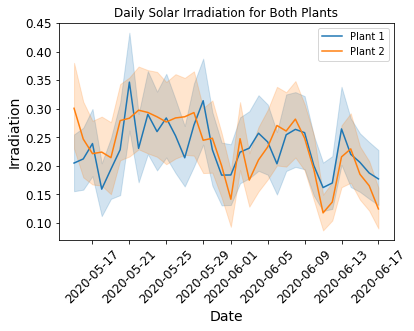

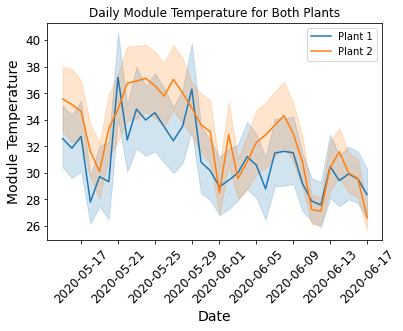

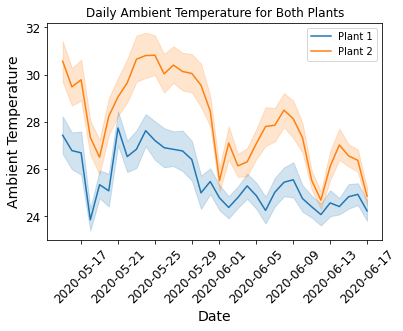

In [130]:
# Comparing both plants
# Daily Irradiation
ambient_compare = sns.lineplot(x='DATE', y='IRRADIATION', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='IRRADIATION', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambient_compare)
plt.ylabel('Irradiation')
plt.xlabel('Date')
plt.title('Daily Solar Irradiation for Both Plants')
plt.xticks(rotation=45)
plt.show()

# Daily Module Temperature
modtemp_compare = sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=modtemp_compare)
plt.ylabel('Module Temperature')
plt.xlabel('Date')
plt.title('Daily Module Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()

# Daily Ambient Temperature
ambtemp_compare = sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambtemp_compare)
plt.ylabel('Ambient Temperature')
plt.xlabel('Date')
plt.title('Daily Ambient Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()


In [118]:
# The mean of solar Irradiation for both plants are similar
mean_irradiationplant1 = plant_1_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant1', mean_irradiationplant1)
mean_irradiationplant2 =  plant_2_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant2', mean_irradiationplant2)

Mean of solar irradition from Plant1 0.22831283006565095
Mean of solar irradition from Plant2 0.23273697972872875


In [119]:
# The mean of Module Temperature for both plants (Plant 1 is lower then Plant 2)
mean_moduletempplant1 = plant_1_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_moduletempplant1)
mean_moduletempplant2 =  plant_2_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_moduletempplant2)

Mean of Module Temperature from Plant1 31.091015378426455
Mean of Module Temperature from Plant2 32.77240792902506


In [12]:
# The mean of Ambient Temperature for both plants (Plant 1 is lower then Plant 2)
mean_ambienttempplant1 = plant_1_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_ambienttempplant1)
mean_ambienttempplant2 =  plant_2_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_ambienttempplant2)

Mean of Module Temperature from Plant1 25.531605717564393
Mean of Module Temperature from Plant2 28.06939988232112


In [131]:
# drop unwanted columns. 
df_weather1 = plant_1_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant1 = plant_1_gen.drop(['PLANT_ID'], axis=1)
df_weather2 = plant_2_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant2 = plant_2_gen.drop(['PLANT_ID'], axis=1)

In [139]:
#Formatedattime
df_plant1['DATE_TIME']= pd.to_datetime(df_plant1['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_weather1['DATE_TIME']= pd.to_datetime(df_weather1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
#df_plant1.head()
df_plant2['DATE_TIME']= pd.to_datetime(df_plant2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_weather2['DATE_TIME']= pd.to_datetime(df_weather2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')



In [122]:
#Merge the dataset
df_plant_weather1 = df_plant1.merge(df_weather1, left_on='DATE_TIME', right_on='DATE_TIME')
df_plant_weather1.head()


,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,00:00:00,2020-05-15


In [140]:
#Merge the dataset
df_plant_weather2 = df_plant2.merge(df_weather2, left_on='DATE_TIME', right_on='DATE_TIME')
df_plant_weather2.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,00:00:00,2020-05-15


######Data Correlation Analysis########

Observations:
1. High correlation between DC Power and AC power generation
2. High correlation between DC Power and IRRADIATION
3. Strong correlation between DC Power, AC Power and Module Temperature and Ambient Temperature

In [142]:
corr_matrix = df_plant_weather1.corr()


In [17]:
corr_matrix["DC_POWER"].sort_values(ascending=False)

DC_POWER               1.000000
AC_POWER               0.999996
IRRADIATION            0.989391
MODULE_TEMPERATURE     0.954811
AMBIENT_TEMPERATURE    0.724668
DAILY_YIELD            0.082243
TOTAL_YIELD            0.003851
Name: DC_POWER, dtype: float64

Saving figure scatter_matrix_plot


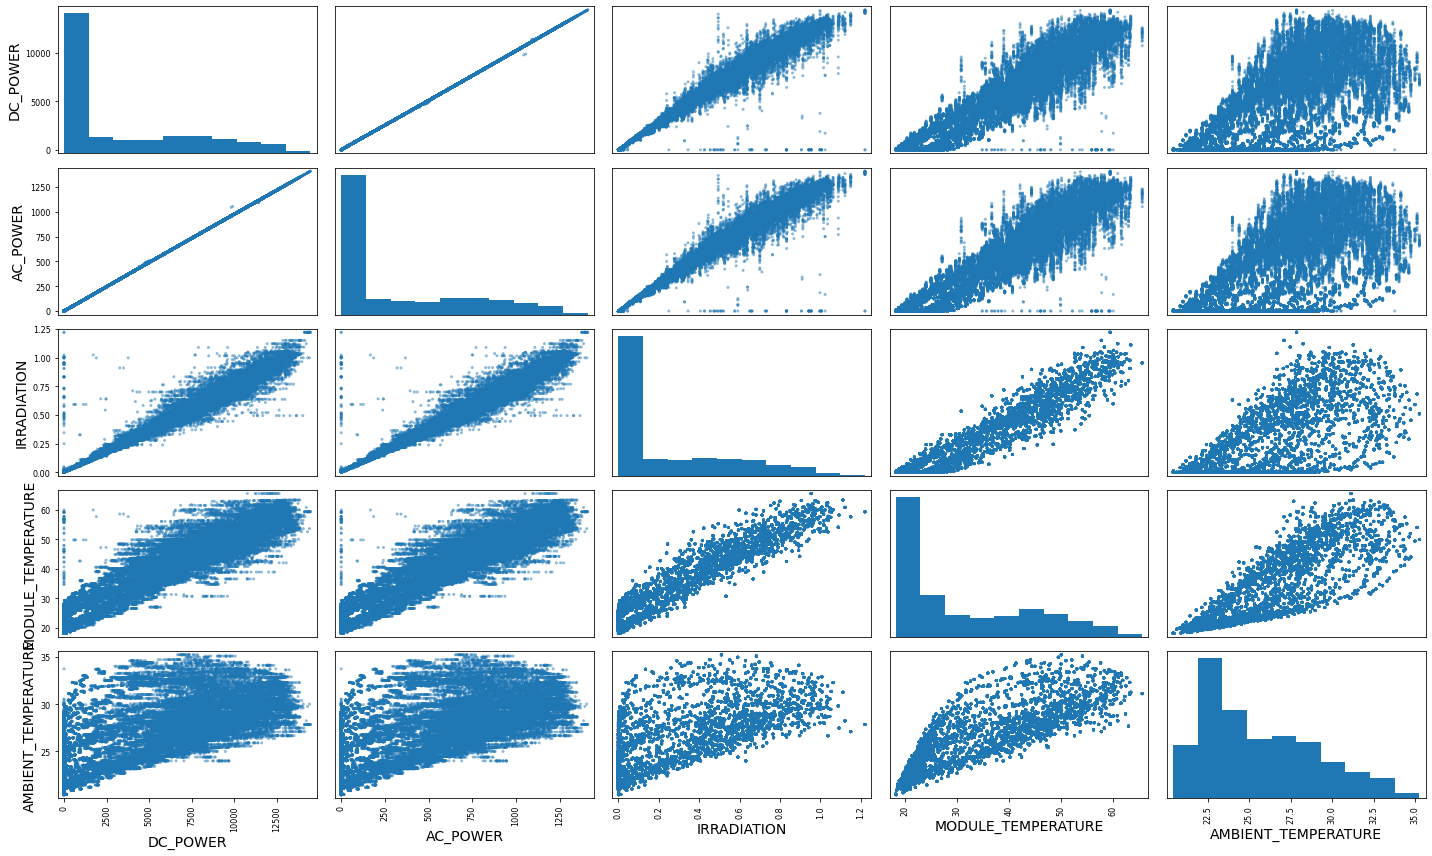

In [18]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Data_analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


attributes = ["DC_POWER", "AC_POWER", "IRRADIATION",
              "MODULE_TEMPERATURE","AMBIENT_TEMPERATURE"]
scatter_matrix(df_plant_weather1[attributes], figsize=(20, 12))
save_fig("scatter_matrix_plot")

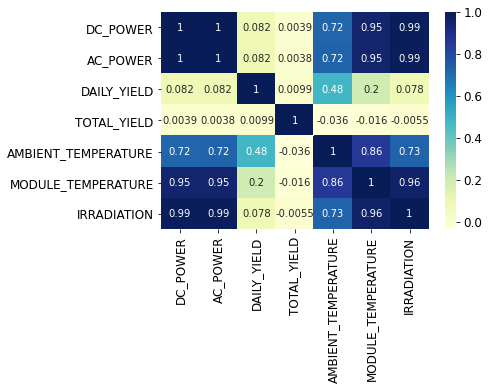

In [45]:
fig_corr = sns.heatmap(corr_matrix,cmap="YlGnBu", annot=True)
plt.show()

Analysis of DC power generated from each Source Keys.
1. TheDistribution DC power generation plot shows multiple occasion where power generated was zero during daytime.
2.  plot of solar irradiation exhibits that the solar radiation never dropped to a lower value at day time. 
3. Analysis shows some inverters received no DC power even through there was enough sunlight
4. It could be concluded that the DC power generated and solar irradiation has a linear relationship.

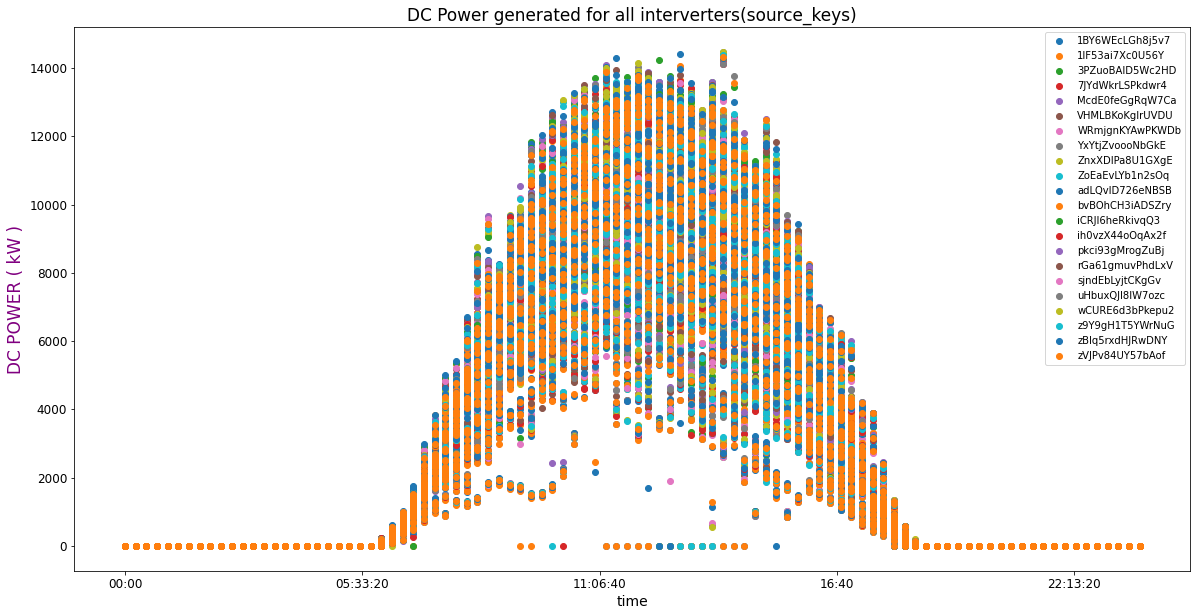

In [49]:
#DC power generated from each source keys
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power generated for all interverters(source_keys)',size=17)
plt.ylabel('DC POWER ( kW )',color='purple',fontsize=17)
plt.show()

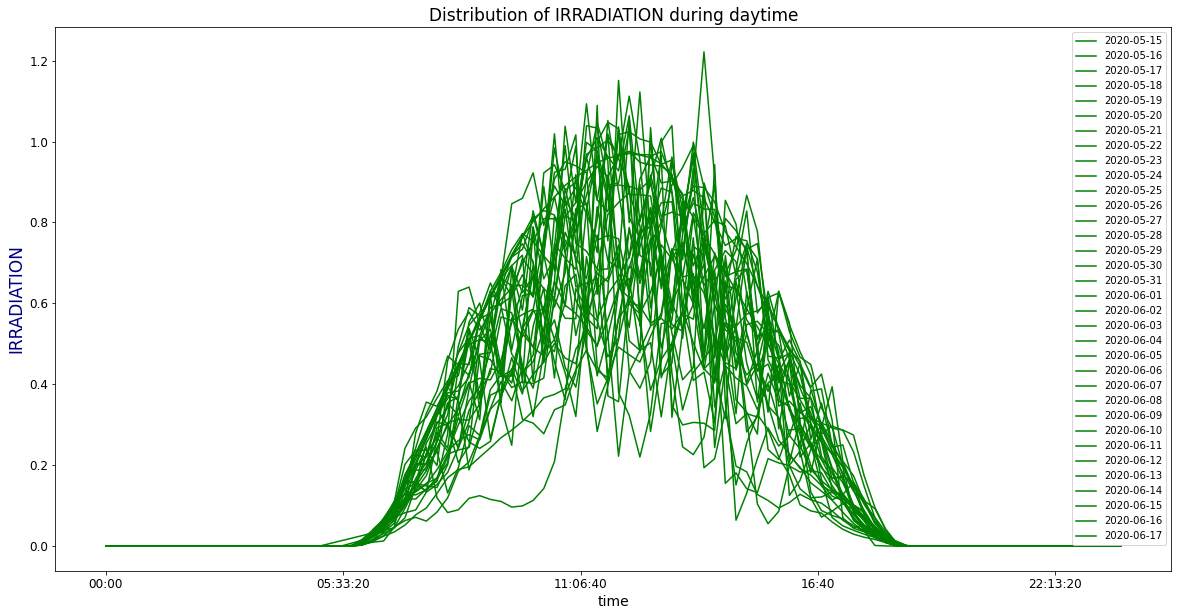

In [20]:
#Solar IRRADIATION generated for days
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources['date']=sources['DATE_TIME'].dt.date
sources.set_index('time').groupby('date')['IRRADIATION'].plot(style='g',legend=True,figsize=(20,10))
plt.title('Distribution of IRRADIATION during daytime',size=17)
plt.ylabel('IRRADIATION',color='navy',fontsize=17)
plt.show()

In [165]:
#Inverters with lower performace then rest "1BY6WEcLGh8j5v7", "bvBOhCH3iADSZry"
SOURCE = dc_gen.groupby('SOURCE_KEY').agg({'DC_POWER': ['mean', 'min', 'max','median']})
print(SOURCE)

                    DC_POWER                              
                        mean  min          max      median
SOURCE_KEY                                                
1BY6WEcLGh8j5v7  2873.720981  0.0  13335.14286  302.955357
1IF53ai7Xc0U56Y  3225.125523  0.0  14302.71429  450.526786
3PZuoBAID5Wc2HD  3221.015673  0.0  14351.12500  456.160714
7JYdWkrLSPkdwr4  3132.891955  0.0  14204.00000  438.571429
McdE0feGgRqW7Ca  3211.307245  0.0  14418.42857  439.571429
VHMLBKoKgIrUVDU  3210.102563  0.0  14299.85714  446.714286
WRmjgnKYAwPKWDb  3155.384433  0.0  14116.25000  449.428571
YxYtjZvoooNbGkE  3179.492570  0.0  14466.85714  480.642857
ZnxXDlPa8U1GXgE  3194.059104  0.0  14273.28571  438.258929
ZoEaEvLYb1n2sOq  3139.009808  0.0  14312.71429  451.000000
adLQvlD726eNBSB  3268.305824  0.0  14416.14286  467.678571
bvBOhCH3iADSZry  2828.998291  0.0  12976.00000  285.000000
iCRJl6heRkivqQ3  3196.074675  0.0  14436.28571  442.285714
ih0vzX44oOqAx2f  3097.714161  0.0  14126.42857  428.5714

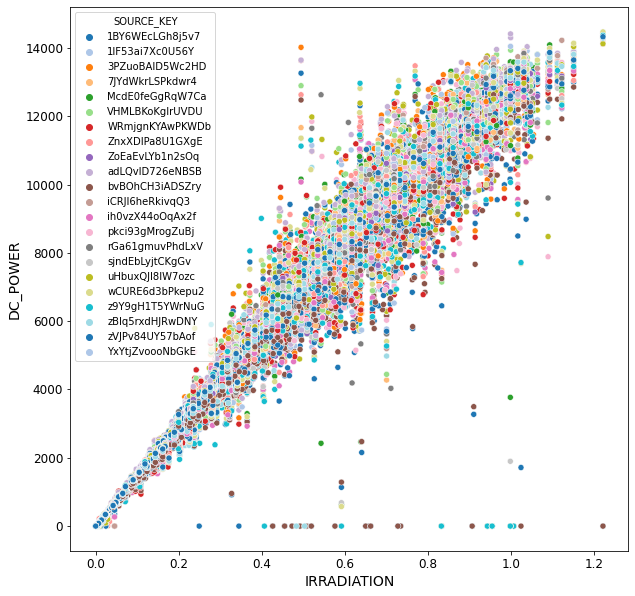

In [24]:
plt.figure(figsize=(10,10))
fig_irr = sns.scatterplot(data=df_plant_weather1, x="IRRADIATION", y="DC_POWER", hue="SOURCE_KEY", palette="tab20")
plt.show()

In [25]:
X = df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features
Y = df_plant_weather1['DC_POWER'] # Target

In [44]:
df_plant_weather1.sample(10)

def make_sample(df,min):
    x = df.copy()
    x.drop("SOURCE_KEY", axis = 1)
    x.set_index("DATE_TIME", inplace = True)
    x.resample(str(min) + " min").mean()
    return x.fillna(0)

df30 = make_sample(df_plant_weather1, 30)
df60 = make_sample(df_plant_weather1, 60)
df2h = make_sample(df_plant_weather1, 120)
df4h = make_sample(df_plant_weather1, 240)

df2h.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68774 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SOURCE_KEY           68774 non-null  object        
 1   DC_POWER             68774 non-null  float64       
 2   AC_POWER             68774 non-null  float64       
 3   DAILY_YIELD          68774 non-null  float64       
 4   TOTAL_YIELD          68774 non-null  float64       
 5   AMBIENT_TEMPERATURE  68774 non-null  float64       
 6   MODULE_TEMPERATURE   68774 non-null  float64       
 7   IRRADIATION          68774 non-null  float64       
 8   TIME                 68774 non-null  object        
 9   DATE                 68774 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 5.8+ MB


In [92]:
X1=df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features 
y1=df_plant_weather1['AC_POWER'] # independent var / predictor

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X1_train.shape)
print("Y Train Shape = ",y1_train.shape)
print("X Test Shape  = ",X1_test.shape)
print("Y Test Shape  = ",y1_test.shape)

Shape of each Dataset : 
X Train Shape =  (55019, 2)
Y Train Shape =  (55019,)
X Test Shape  =  (13755, 2)
Y Test Shape  =  (13755,)


In [93]:
lm = LinearRegression()

In [94]:
 #fit on training data
lm.fit(X1_train, y1_train)
lm.intercept_, lm.coef_

(89.01209177219363, array([-40.38940184,  40.04138528]))

In [95]:
print ('Plant 1 linear regression cofficients are:', X.columns, lm.coef_ )
print('Plant 1 intercept', lm.intercept_)

Plant 1 linear regression cofficients are: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], dtype='object') [-40.38940184  40.04138528]
Plant 1 intercept 89.01209177219363


In [96]:
#Prediction from model
Prediction_plant1 = lm.predict (X1_test)
Prediction_plant1
Y1_pred_train = lm.predict(X1_train)
Y1_pred_test = lm.predict(X1_test)

print ('Prediction Train dataset', Y1_pred_train)
print ('Prediction Train dataset', Y1_pred_test)

Prediction Train dataset [319.24148263 -10.89915161 -11.61392072 ... -24.88904315   2.28030868
 617.23637436]
Prediction Train dataset [1075.8099964    38.91509271   37.92676015 ...  -14.0049295   -12.73072717
  342.26548549]


Text(0, 0.5, 'Actual Output')

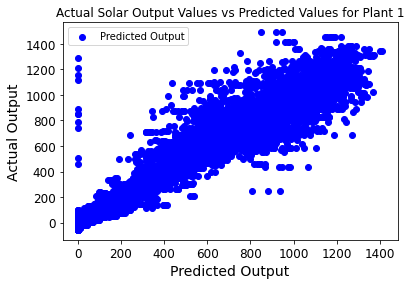

In [97]:

# This also includes faulty days dataset
plt.scatter(y1_test, Y1_pred_test,color="b", label="Predicted Output")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

In [152]:
print("Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)")
print("")
RMSE_train_1 = np.sqrt( metrics.mean_squared_error(y1_train, Y1_pred_train))
RMSE_test_1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
print('RMSE for training set = {}'.format(round(RMSE_train_1,2)))
print('RMSE for test set = {}'.format(round(RMSE_test_1,2)))

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)

RMSE for training set = 94.06
RMSE for test set = 92.88


In [151]:
from sklearn import metrics

# PLANT 1
MAE1 = metrics.mean_absolute_error(y1_test, Y1_pred_test)
MSE1 = metrics.mean_squared_error(y1_test, Y1_pred_test)
RMSE1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
print('Metrics for Plant 1 Linear Model')
print('MAE: ', MAE1)
print('MSE: ',MSE1)
print('RMSE: ', RMSE1)
print()

Metrics for Plant 1 Linear Model
MAE:  55.596344664137256
MSE:  8625.890452699101
RMSE:  92.87567201748314



Model Linear Regression on Plant2

In [167]:
X12=df_plant_weather2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION']] # Features 
y12=df_plant_weather2['AC_POWER'] # independent var / predictor

X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y12, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X12_train.shape)
print("Y Train Shape = ",y12_train.shape)
print("X Test Shape  = ",X12_test.shape)
print("Y Test Shape  = ",y12_test.shape)

Shape of each Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [168]:
lm = LinearRegression()

In [170]:
 #fit on training data
lm.fit(X12_train, y12_train)
lm.intercept_, lm.coef_

(-158.9063334664413, array([  14.31914096,   -7.34317926, 1042.77770477]))

In [171]:
#Prediction from model
Prediction_plant2 = lm.predict (X12_test)
Prediction_plant2
Y12_pred_train = lm.predict(X12_train)
Y12_pred_test = lm.predict(X12_test)

print ('Prediction Train dataset', Y12_pred_train)
print ('Prediction Train dataset', Y12_pred_test)

Prediction Train dataset [720.42986988  14.6652878  869.63077043 ... 892.70017547 437.47378379
 660.91339571]
Prediction Train dataset [667.09310044 489.01766501 724.92861871 ... 680.98490577  38.4763396
  25.58443371]


Text(0, 0.5, 'Actual Output')

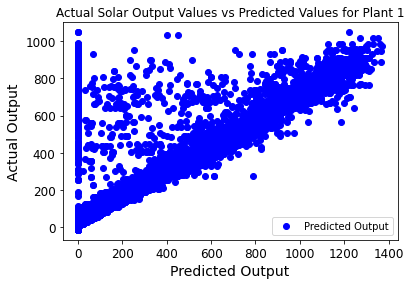

In [172]:

# This also includes faulty days dataset Plant 2
plt.scatter(y12_test, Y12_pred_test,color="b", label="Predicted Output")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

In [173]:
## acuracy score for Plant 2 using Linear Regression
train_score_12 = lm.score(X12_train, y12_train)
test_score_12 = lm.score(X12_test, y12_test)

print("Model 1 Plant 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_12*100,0),"%")
print("Test Score  = ",round(test_score_12*100,0), "%")

Model 1 Plant 2 accuracy score: 

Train Score =  62.0 %
Test Score  =  61.0 %


Model Evaluation for Linear Regression Model 1 for Plant 1

Model 2: Random Forest

In [185]:
## Select columns that will be used to create train and test dataset
model_2 = df_plant_weather2
model_2.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,00:00:00,2020-05-15


In [186]:
## create list using feature columns
#model_2_features = model_2['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# use above list to select subset of original dataframe
#X2 = model_2[model_2_features]
#y3 = model_2["DC_POWER"] # dependent variable / output

X2 = model_2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']] # Features
y2 = model_2['AC_POWER'] # Target

X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.20, random_state=1) 

print("Shape of each New Dataset : ")
print("X Train Shape = ",X2_train.shape)
print("Y Train Shape = ",y2_train.shape)
print("X Test Shape  = ",X2_test.shape)
print("Y Test Shape  = ",y2_test.shape)

Shape of each New Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [187]:

RF = RandomForestRegressor()
RF.fit(X2_train, y2_train)

RandomForestRegressor()

In [188]:
y2_pred_train = RF.predict(X2_train)
y2_pred_test = RF.predict(X2_test)

In [189]:
print("Model Evaluation for Random Forest Model 2 using RMSE")

RMSE_train_2 = np.sqrt( metrics.mean_squared_error(y2_train, y2_pred_train))
RMSE_test_2 = np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_test))
MSE_train_2 = ( metrics.mean_squared_error(y2_train, y2_pred_train))
print('RMSE for training set is {}'.format(round(RMSE_train_2,2)))
print('RMSE for test set is {}'.format(round(RMSE_test_2,2)))
print('MSE for train set is {}'.format(round(MSE_train_2,2)))

Model Evaluation for Random Forest Model 2 using RMSE
RMSE for training set is 193.54
RMSE for test set is 211.12
MSE for train set is 37456.04


In [190]:
## acuracy scorefor Model 2
## acuracy score
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  71.0 %
Test Score  =  66.0 %


Text(0, 0.5, 'Actual Output')

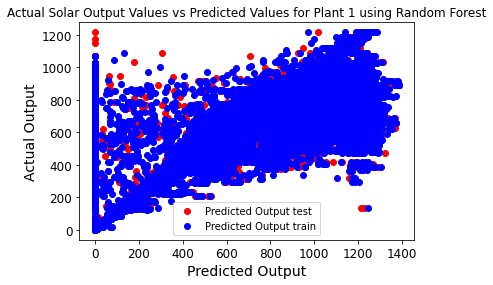

In [191]:
# This also includes faulty days dataset
plt.scatter(y2_test, y2_pred_test,color="r", label="Predicted Output test")
plt.scatter(y2_train, y2_pred_train,color="b", label="Predicted Output train")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1 using Random Forest')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

In [192]:
#Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X2_train)
X_test = sc.transform(X2_test)

In [195]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X2_train, y2_train)
y3_pred = regressor.predict(X2_test)


In [196]:
## acuracy scorefor Model 2 after scaling data
## acuracy score
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  71.0 %
Test Score  =  66.0 %
